In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class_names = ['Cat', 'Dog']
# extract images in dataset
cat_set = 'drive/MyDrive/cat_dog_classification/PetImages/Cat'
dog_set= 'drive/MyDrive/cat_dog_classification/PetImages/Dog'

# number of rows in dataset
n_dogs = len(cat_set)
n_cats = len(dog_set)

# plot number of images in the dataset
n_images = [n_cats, n_dogs]
fig = px.bar(x=class_names, y=n_images, labels={'x': 'Class', 'y': 'Number of Images'})
fig.show()

In [4]:
import shutil

# Define paths
source_dir = 'drive/MyDrive/cat_dog_classification/PetImages'
target_dir = 'cats_dogs2'

# Create target directories
os.makedirs(target_dir, exist_ok=True)
os.makedirs(os.path.join(target_dir, 'training', 'Cats'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'training', 'Dogs'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'validation', 'Cats'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'validation', 'Dogs'), exist_ok=True)


# Split ratio
train_ratio = 0.8
val_ratio = 0.2


# Iterate through each class (cats and dogs)
for class_name in ['Cat', 'Dog']:
    class_dir = os.path.join(source_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    # Calculate split points
    num_images = len(images)
    num_train = int(train_ratio * num_images)
    num_val = int(val_ratio * num_images)

    # Assign images to train, validation, and test sets
    train_images = images[:num_train]
    val_images = images[num_train:]


    # Copy images to respective directories
    for image in train_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(target_dir, 'training', class_name + 's'))
    for image in val_images:
        shutil.copy(os.path.join(class_dir, image), os.path.join(target_dir, 'validation', class_name + 's'))
    # for image in test_images:
    #     shutil.copy(os.path.join(class_dir, image), os.path.join(target_dir, 'test', class_name + 's'))

In [5]:
import PIL
from PIL import Image

In [6]:
# Data cleaning
folder_paths = [
    'cats_dogs2/training/Cats',
    'cats_dogs2/training/Dogs',
    'cats_dogs2/validation/Cats',
    'cats_dogs2/validation/Dogs'
]
for folder_path in folder_paths:
  for filename in os.listdir(folder_path):
      try:
          image = Image.open(os.path.join(folder_path, filename))
      except PIL.UnidentifiedImageError as e:
          print(f"Error in file {filename}: {e}")
          os.remove(os.path.join(folder_path, filename))
          print(f"Removed file {filename}")

Error in file Thumbs.db: cannot identify image file 'cats_dogs2/training/Cats/Thumbs.db'
Removed file Thumbs.db
Error in file 11702.jpg: cannot identify image file 'cats_dogs2/training/Dogs/11702.jpg'
Removed file 11702.jpg
Error in file Thumbs.db: cannot identify image file 'cats_dogs2/validation/Dogs/Thumbs.db'
Removed file Thumbs.db


In [7]:
# data normalization
train_gen = ImageDataGenerator(
        rescale=1./255)

validation_gen =  ImageDataGenerator(
        rescale=1./255.)

In [8]:
train_generator = train_gen.flow_from_directory(
        'cats_dogs2/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        'cats_dogs2/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')


Found 2278 images belonging to 2 classes.
Found 571 images belonging to 2 classes.


img shape (150, 150, 3)
label- Dog


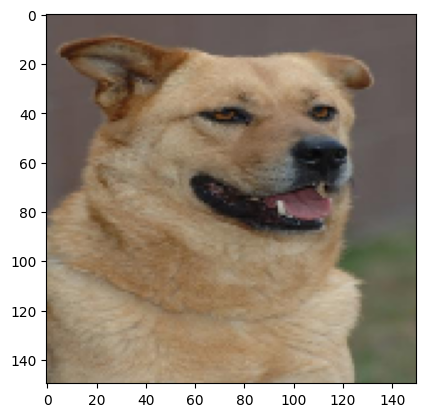

In [9]:
# plot validation images

for img,lbl in validation_generator:
  print('img shape',img[0].shape)
  if lbl[0] == 1:
    cls = 'Dog'
  else:
    cls = 'Cat'
  print('label-',cls)
  plt.imshow(img[0])
  plt.show()
  break

In [10]:
IMG_HEIGHT=150
IMG_WIDTH=150

In [11]:

def feature_extractor(inputs):
    print('feature_extractor--input',inputs.shape)
    # print('')
    resnet_feature_extractor = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights="imagenet")
    features = resnet_feature_extractor(inputs)
    return features

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)
    print('classifier--',x.shape)
    return x

def final_model(inputs):
    resnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

    return model

# Example usage:
model = define_compile_model()
model.summary()

feature_extractor--input (None, 150, 150, 3)
94765736/94765736 [==============================] - 1s 0us/step
classifier-- (None, 2)
classification_output-- (None, 2)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 23538690 (89.79 MB)
Non-trainable params

In [12]:
# freezing ResNet50 Layers
model.layers[1].trainable = False

# model training
r = model.fit(
    x=train_generator,
    epochs=20,  # Training longer could yield better results
    validation_data=validation_generator
)

Epoch 1/20
36/36 [==============================] - 50s 568ms/step - loss: 0.9619 - accuracy: 0.7006 - val_loss: 16.5189 - val_accuracy: 0.6760
Epoch 2/20
36/36 [==============================] - 13s 369ms/step - loss: 0.6121 - accuracy: 0.7862 - val_loss: 7066.9600 - val_accuracy: 0.3240
Epoch 3/20
36/36 [==============================] - 15s 407ms/step - loss: 0.3974 - accuracy: 0.8507 - val_loss: 0.6827 - val_accuracy: 0.6760
Epoch 4/20
36/36 [==============================] - 14s 376ms/step - loss: 0.2422 - accuracy: 0.9039 - val_loss: 0.6833 - val_accuracy: 0.6760
Epoch 5/20
36/36 [==============================] - 14s 377ms/step - loss: 0.1388 - accuracy: 0.9491 - val_loss: 0.6363 - val_accuracy: 0.6760
Epoch 6/20
36/36 [==============================] - 14s 379ms/step - loss: 0.1102 - accuracy: 0.9579 - val_loss: 0.6867 - val_accuracy: 0.6760
Epoch 7/20
36/36 [==============================] - 14s 382ms/step - loss: 0.0882 - accuracy: 0.9644 - val_loss: 0.7361 - val_accuracy: 0.

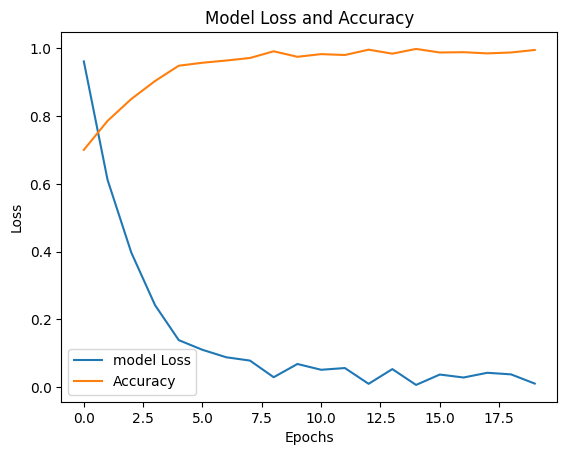

In [13]:
# plot model training loss and accuracy

plt.plot(r.history['loss'], label='model Loss')
plt.plot(r.history['accuracy'], label='Accuracy')
plt.title("Model Loss and Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [15]:
model.save('drive/MyDrive/cat_dog_classification/model2.keras')

img shape 0 (150, 150, 3)
2/2 [==============================] - 0s 68ms/step
predictions-- 0
original-- 0
model Prediction- Cat


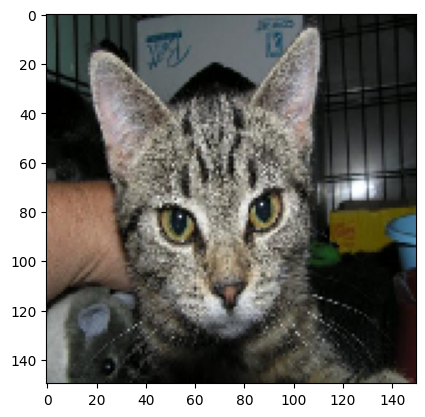

In [42]:
# Model prediction

for i,(img,lbl) in enumerate(validation_generator):
  print('img shape',i,img[0].shape)
  preds = model.predict(img)
  predictions = np.argmax(preds, axis=1)

  predictions[i]
  print('predictions--',predictions[i])
  print('original--',int(lbl[i]))

  if lbl[i] == predictions[i]:
    cls = 'Dog'
  else:
    cls = 'Cat'
  print('model Prediction-',cls)
  plt.imshow(img[0])
  plt.show()
  break